# SkimLit Function

Harder to read --> easier to read

It will seperate a difficult text to Objective, methods, results, conclusions.

Types:
* Many to one: input would be an abstract // output would be an objective

* Data from PubMEd 200K RCT
* Write a **preprocessing function** for the text data
* Setting up multiple modelling experiments with different levels of **embeddings**
* building a **multimodal model** to take in different sources of data
 * **Replicating** the model powering https://arxiv.org/abs/1710.06071
* finding the most incorrect prediction examples.

* Download the text dataset
* Writing a preprocessing function to prepare data for modellinh
* setting up a series of modeling experiments
  * making a baseline (TF-IDF Classifier)
  * Deep models with different combinations of token embeddings, character embeddings, pretrained embeddings, positional embeddings.
* Building our first multimodal model
 * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most incorrect predictions
* Make predictions on PubMed abstracts from the wild!

In [181]:
import datetime
# print(f"Notebook last run (end-to-end):" {datetime.datetime.now()})

In [182]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e4e9a6c0-806e-89c9-2c80-a272672493b9)


# evaluate model Func

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# how should we evaluate our model?

# Function to evaluate: accuracy, precision, recall, f1-score


def evaluate_model(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [7]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 32.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [8]:
# Check which files are in PubMed_20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [9]:
#dev is another word for validation set.
# can colab view a txt? YES
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [10]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocessing the data

Now we got some text data. time to become one with it.

One of the best ways to become one with the data is to...

> Visualize, visualize, visualize

With that in mind time to make a function to read all the lines in the target text file

In [11]:

def read_lines(filepath):
  with open(filepath) as file:
    lines = file.readlines()
  return lines

In [12]:
train_lines = read_lines(data_dir + "train.txt")
train_lines[10:25]

['RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n',
 '###24854809\n',
 'BACKGROUND\tEmotional eating is associated with overeating and the development of obesity .\n',
 'BACKGROUND\tYet , empirical evidence for individual ( trait ) differences in emotional eating and cognitive mechanisms that contribute to eating during sad mood remain equivocal .\n',
 'OBJECTIVE\tThe aim of this study was to test if attention bias for food moderates the effect of self-reported emotional eating during sad mood ( vs ne

In [13]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represent the data

line_number : 0

target: BACKGROUND,

text: Emotional eating is associated with overeating and the development of obesity

Total_lines: 11

In [14]:
def preprocess_text_line_number(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, read it contents and sorts through each line,
  extract things like:
   * target label
   * text of each sentence,
   * number of sentences
   * which sentence number of target line
   """

  input_lines = read_lines(filename)
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'):  #'###24854809\n',
       abstract_id = line
       abstract_lines = ""  # reset the abstract string if the line is an ID line
    elif line.isspace():  # Checks if its a new line (\n)
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and count them at the same time.
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label from text.
        line_data["text"] = target_text_split[1].lower() # get target text and lower it?
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the line? starts from 0
        abstract_samples.append(line_data)
    else:  # if the above conditions aren't fulfilled, the line contains a labelled sentence.

      abstract_lines += line
  return abstract_samples

In [15]:
%%time
train_dir = data_dir + "train.txt"
train_samples = preprocess_text_line_number(train_dir)
val_samples = preprocess_text_line_number(data_dir + "dev.txt")
test_samples = preprocess_text_line_number(data_dir +"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 410 ms, sys: 104 ms, total: 513 ms
Wall time: 510 ms


In [16]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, we can turn it into a dataframe to visualize it.

In [17]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [18]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

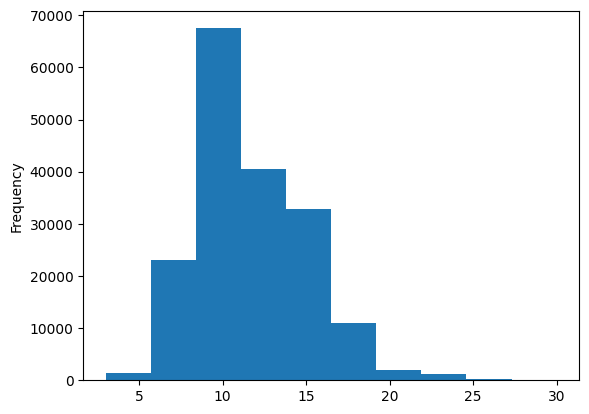

In [19]:
# We should check the length of each line
train_df.total_lines.plot.hist()

### Get list of sentences

In [20]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [21]:
len(train_sentences)

180040

In [22]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels (Right now we have 5)

ML models require numeric labels. We could one hot encoded labels

In [23]:
# One hot encoded labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encode = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encode.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encode.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encode.transform(test_df.target.to_numpy().reshape(-1,1))


### Label Encode labels

In [24]:
# Extract labels ("Target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [25]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [203]:
# lets build with Naive Bayes  --> Create a tfidf
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # models it using Naive bayes
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
# Pipeline is in steps, each step has a name
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), # convert words to numbers
    ('clf', MultinomialNB()) # model the text
])
model_0

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [204]:
baseline_model = model_0.fit(train_sentences, train_labels_encoded)

In [205]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score

0.7218323844829869

In [206]:
baseline_pred = model_0.predict(val_sentences)


In [207]:
baseline_pred[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

# Baseline results

In [208]:
#Download the helper function script for prediction comparison
baseline_results = evaluate_model(baseline_pred, val_labels_encoded)
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7835634520695112,
 'recall': 0.7218323844829869,
 'f1': 0.7447397336209445}

## Max sentence lens and max token needs

In [28]:
max_len = sum(len(sentence.split()) for sentence in train_sentences)
max_len

4741942

In [29]:
single_sentence_len = [len(sentence.split()) for sentence in train_sentences]

In [30]:
import numpy as np
sentence_len = round(max_len / len(train_sentences))
sentence_len

26

(0.0, 100.0)

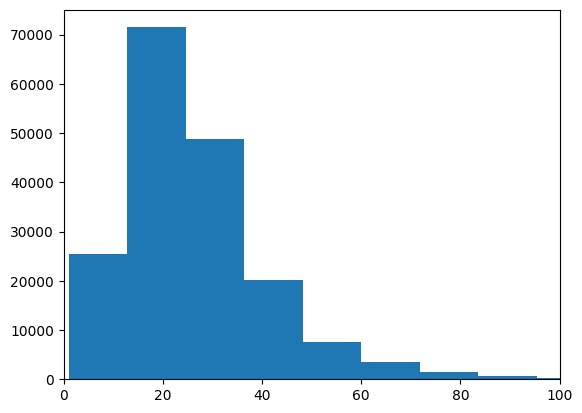

In [31]:
import matplotlib.pyplot as plt
import matplotlib.axes
plt.hist(single_sentence_len, bins=25)
plt.xlim(0,100)

In [32]:
# How long of a sentence length covers 95 of the examples?

output_sequence_length = int(np.percentile(single_sentence_len,95))
output_sequence_length
# This shows that 95% of sentences are within 55 tokens


55

In [33]:
max_single_sentence_len = max(single_sentence_len)
max_single_sentence_len

296

## Vectorize_layer

setup text vectorization layer.

In [34]:
# Text vectorizer and customer embedding layer.
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 # given by paper // 331000 for 200k

vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    standardize = "lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams = None,
                                    output_mode = 'int',
                                    output_sequence_length = output_sequence_length,
                                    pad_to_max_tokens=True)

In [35]:
vectorize_layer.adapt(train_sentences) # Cause the model to build an index of strings to integers


In [217]:
train_sentences[1] , vectorize_layer(train_sentences[1]), vectorize_layer(train_sentences[1]).shape

('a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 <tf.Tensor: shape=(55,), dtype=int64, numpy=
 array([   8,   76,    4,   12,    7,   56,  517, 1743,    9,   29,   80,
         744,    4, 2535,    3,   80,   48,   11,   53,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>,
 TensorShape([55]))

In [36]:
# How many words in our training vocab?

rct_20k_text_vocab =  vectorize_layer.get_vocabulary()
print(f'len: {len(rct_20k_text_vocab)}')
print(f'most common words: {rct_20k_text_vocab[:10]}')
print(f'least common words: {rct_20k_text_vocab[-10:]}')

len: 64841
most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
least common words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim= len(rct_20k_text_vocab),
                             output_dim = 128,
                             mask_zero =True,
                             name = "token_embedding"
                             )
embedding

In [220]:
train_sentences[1] , vectorize_layer(train_sentences[1]) , embedding(vectorize_layer(train_sentences[1]))

('a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 <tf.Tensor: shape=(55,), dtype=int64, numpy=
 array([   8,   76,    4,   12,    7,   56,  517, 1743,    9,   29,   80,
         744,    4, 2535,    3,   80,   48,   11,   53,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>,
 <tf.Tensor: shape=(55, 128), dtype=float32, numpy=
 array([[ 0.04215303,  0.01996456, -0.01101186, ...,  0.03410158,
          0.0128369 , -0.01299632],
        [ 0.04003999, -0.04708985, -0.01753116, ...,  0.00090458,
          0.0299666 , -0.02184142],
        [ 0.04178524,  0.01477385,  0.01711592, ..., -0.00406504,
          0.00227556,  0.00812541],
        ...,
        [-0.00823035, -0.01612936, -0.01502551, ..., -0.02774388,
  

In [221]:
print(f'embedding shape: {embedding(vectorize_layer(train_sentences[1])).shape}')

embedding shape: (55, 128)


## Creating datasets ( making sure our data loads as fast as possible)

we're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance

* https://www.tensorflow.org/guide/data


In [222]:
import tensorflow as tf

import time
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

In [223]:
# Example
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)
benchmark(ArtificialDataset())

Execution time: 0.2952520849994471


In [224]:
train_sentences[1], train_labels_one_hot[1]

('a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 array([0., 0., 1., 0., 0.]))

In [71]:
# Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [72]:
# Take the TensorSliceDataset's and turn them into prefected datasets.
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [227]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Conv1D with token embeddings

In [228]:
# Conv1D with token embeddings

inputs = layers.Input(shape = (1,), dtype=tf.string)
text_vectors = vectorize_layer(inputs)
token_embeddings = embedding(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation ="relu")(token_embeddings)
x =  layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(6, activation = "relu")(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x) #(5 different labels)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")

In [229]:
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_5 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                           

In [230]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [231]:
history_1 = model_1.fit(train_dataset,
                        epochs = 3,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = val_dataset,
                        validation_steps = int(0.1* len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.9235 - accuracy: 0.6338 - val_loss: 0.6843 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6575 - accuracy: 0.7565 - val_loss: 0.6348 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6185 - accuracy: 0.7732 - val_loss: 0.5968 - val_accuracy: 0.7882


In [232]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5985 - accuracy: 0.7856


[0.5984672904014587, 0.7855818867683411]

In [233]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.2211509e-01, 1.6561635e-01, 8.7013647e-02, 2.9793531e-01,
         2.7319686e-02],
        [4.8261848e-01, 2.4455100e-01, 1.3501824e-02, 2.5063333e-01,
         8.6955288e-03],
        [1.4403643e-01, 6.4914203e-03, 1.4987859e-03, 8.4791875e-01,
         5.4542557e-05],
        ...,
        [3.1507382e-06, 4.9596769e-04, 6.1654265e-04, 2.8169675e-06,
         9.9888152e-01],
        [6.7855284e-02, 4.6349517e-01, 9.8347984e-02, 7.0226200e-02,
         3.0007535e-01],
        [1.7985474e-01, 6.9032115e-01, 4.6328023e-02, 3.4982715e-02,
         4.8513405e-02]], dtype=float32),
 (30212, 5))

In [234]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [235]:
model_1_results= evaluate_model(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 0.7855818879915265,
 'precision': 0.7823287137673377,
 'recall': 0.7855818879915265,
 'f1': 0.7832531508401749}

# Tensorflow Hub Pretrained Feature Extractor

We can try using the USE ( universal Sentence encoder)

In [236]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)
print("module %s loaded" % model_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [237]:
# Model 2: Feature extraction using pretrained.
tf_hub_embedding_layer = hub.KerasLayer(model_url, trainable = False,
                                 name = "Universal_sentence_encoder")


In [238]:
import random

random_train_sentence =  random.choice(train_sentences)
print(random_train_sentence)
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])

print(len(use_embedded_sentence))

the study was carried out as an open-label , randomized controlled trial with @ sequential patients recruited .
1


In [239]:
# tensorflow input / hub embed layer / dense layer on top (5)

inputs = layers.Input(shape=[], dtype = tf.string)
# text_vectors = vectorize_layer(inputs)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(x)
# x =  layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)


In [240]:
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [241]:
model_2.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")

In [242]:
model_2.fit(train_dataset,
            epochs = 3,
            steps_per_epoch = int(0.1*len(train_dataset)),
            validation_data = val_dataset,
            validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9166 - accuracy: 0.6505 - val_loss: 0.7970 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7699 - accuracy: 0.7013 - val_loss: 0.7552 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7539 - accuracy: 0.7127 - val_loss: 0.7407 - val_accuracy: 0.7131


In [243]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.7431 - accuracy: 0.7126


[0.7430504560470581, 0.7126307487487793]

In [244]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 18s 19ms/step


(array([[4.6462366e-01, 3.3564380e-01, 2.3765620e-03, 1.9003160e-01,
         7.3244856e-03],
        [3.7510318e-01, 4.4861832e-01, 3.9301100e-03, 1.6947979e-01,
         2.8686647e-03],
        [2.3524280e-01, 1.7467299e-01, 1.8972462e-02, 5.2986389e-01,
         4.1247897e-02],
        ...,
        [1.9000844e-03, 5.8998186e-03, 5.8173589e-02, 8.0528599e-04,
         9.3322122e-01],
        [4.1658236e-03, 4.7537606e-02, 1.8220910e-01, 1.3366260e-03,
         7.6475078e-01],
        [1.9072564e-01, 2.6829156e-01, 4.6978673e-01, 6.7565660e-03,
         6.4439423e-02]], dtype=float32),
 (30212, 5))

In [245]:
model_2_predictions = tf.argmax(model_2_pred_probs, axis= 1)
model_2_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [246]:
model_2_results = evaluate_model(val_labels_encoded, model_2_predictions)
model_2_results

{'accuracy': 0.7126307427512247,
 'precision': 0.7130668795387521,
 'recall': 0.7126307427512247,
 'f1': 0.7095808349630283}

## Model 3 Character embedding vs token embedding

The paper used a combination of token and character embeddings.

Token [I, Love, Coding]

Character level [ I, L,o,v,e , , ,C,o,d,i,n,g]

In [247]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character level sequence into characters
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [248]:
train_char = [split_chars(sentence) for sentence in train_sentences]
val_char = [split_chars(sentence) for sentence in val_sentences]
test_char = [split_chars(sentence) for sentence in test_sentences]
train_char[0:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [249]:
# Whats the average char lens?
char_len= [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

(array([2.0600e+03, 1.0281e+04, 2.1922e+04, 2.8139e+04, 3.0289e+04,
        2.6219e+04, 1.9853e+04, 1.4492e+04, 9.6420e+03, 6.1370e+03,
        4.0170e+03, 2.5600e+03, 1.5340e+03, 9.3500e+02, 6.4300e+02,
        4.4600e+02, 2.5600e+02, 1.8800e+02, 1.1900e+02, 8.0000e+01,
        5.8000e+01, 4.7000e+01, 2.6000e+01, 2.4000e+01, 1.2000e+01,
        1.2000e+01, 1.0000e+01, 9.0000e+00, 7.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 2.8700e+01, 5.6400e+01, 8.4100e+01, 1.1180e+02,
        1.3950e+02, 1.6720e+02, 1.9490e+02, 2.2260e+02, 2.5030e+02,
        2.7800e+02, 3.0570e+02, 3.3340e+02, 3.6110e+02, 3.8880e+02,
        4.1650e+02, 4.4420e+02, 4.7190e+02, 4.9960e+02, 5.2730e+02,
        5.5500e+02, 5.8270e+02, 6.1040e+02, 6.

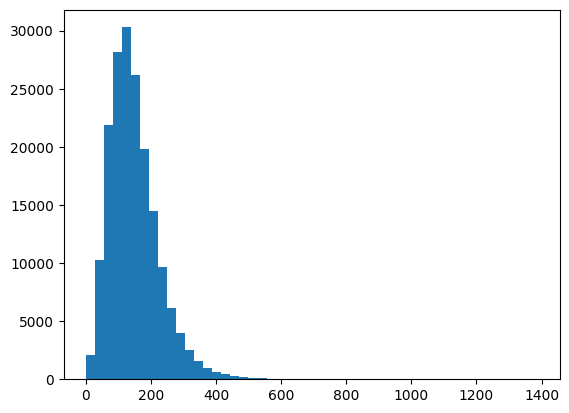

In [250]:
import matplotlib.pyplot as plt
plt.hist(char_len, bins = 50)

In [251]:
# Find char len covering 95% of sequences

output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [252]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase +string.digits +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [253]:
# Create char level token vectorizer instance
char_vectorizer = TextVectorization(
    max_tokens = len(alphabet)+2,
    output_sequence_length = output_seq_char_len,
    name="char_vectorizer")

In [254]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_char)

In [255]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'length{len(char_vocab)}')
print(f'{char_vocab[:5]} most used')
print(f'{char_vocab[-5:]} least used')

length28
['', '[UNK]', 'e', 't', 'i'] most used
['k', 'x', 'z', 'q', 'j'] least used


In [256]:
random_train_chars = random.choice(train_char)
print(random_train_chars)
vectorized_char = char_vectorizer([random_train_chars])
print(vectorized_char)

a f t e r   t h e   f i r s t   d a y   o f   t r e a t m e n t   ,   t h e   p a t i e n t s   w e r e   v i s i t e d   o n   t h e   @ r d   ,   @ t h   ,   @ t h   ,   @ t h   ,   a n d   @ s t   d a y   .
tf.Tensor(
[[ 5 17  3  2  8  3 13  2 17  4  8  9  3 10  5 19  7 17  3  8  2  5  3 15
   2  6  3  3 13  2 14  5  3  4  2  6  3  9 20  2  8  2 21  4  9  4  3  2
  10  7  6  3 13  2  8 10  3 13  3 13  3 13  5  6 10  9  3 10  5 19  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  


## Character level embedding

In [257]:
char_embedding_layer = layers.Embedding(input_dim = len(char_vocab),
                                        output_dim = 25, #from paper
                                        mask_zero = True,
                                        name = "char_embed_layer")

In [258]:
print(char_embedding_layer(vectorized_char))

tf.Tensor(
[[[-0.01920438 -0.01449475 -0.02027098 ...  0.04545367 -0.02538278
    0.01041216]
  [ 0.00147156 -0.01211657 -0.04714605 ... -0.01817352  0.04024596
    0.03968099]
  [-0.03681595 -0.02006257 -0.03970242 ... -0.01931133 -0.03989851
   -0.01256333]
  ...
  [-0.02199576 -0.03377658  0.00643636 ...  0.01896879 -0.04724304
    0.03455954]
  [-0.02199576 -0.03377658  0.00643636 ...  0.01896879 -0.04724304
    0.03455954]
  [-0.02199576 -0.03377658  0.00643636 ...  0.01896879 -0.04724304
    0.03455954]]], shape=(1, 290, 25), dtype=float32)


In [259]:
# need to setup the training dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [260]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embedding = char_embedding_layer(char_vector)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(char_embedding)
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax", name ="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")

In [261]:
model_3.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed_layer (Embeddin  (None, 290, 25)           700       
 g)                                                              
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               46080     
 onal)                                                           
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                          

In [262]:
history_3 = model_3.fit(train_char_dataset,
            epochs = 3,
            steps_per_epoch = int(0.1*len(train_char_dataset)),
            validation_data = val_dataset,
            validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 43ms/step - loss: 1.3430 - accuracy: 0.4317 - val_loss: 1.4907 - val_accuracy: 0.3697
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 1.2235 - accuracy: 0.4934 - val_loss: 1.4709 - val_accuracy: 0.3657
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 1.1654 - accuracy: 0.5207 - val_loss: 1.4792 - val_accuracy: 0.3457


In [263]:
model_3.evaluate(val_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 1.4674 - accuracy: 0.3534


[1.4674482345581055, 0.3534357249736786]

In [264]:
model_3_pred_probs = model_3.predict(val_dataset)
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)

945/945 [==============================] - 9s 7ms/step


In [265]:
model_3_results = evaluate_model(val_labels_encoded, model_3_pred)

# Model 4: Combining pretrained token embedding + characters embedding ( make hybrid layering)

1. Create a token level embedding model --Model 1
2. Create a character level embedding model -- Model 3
3. Combine both models with a layers.Concatenate
4. Build a series of output layers on top of 3
5. Construct a model which takes token and char-level sequences as input and produce sequence label probabilities as output

In [266]:
# 1. Setup token input model
token_inputs = layers.Input(shape =[], dtype =tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs
                             , outputs = token_outputs)

# 2. Setup character input model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vector = char_vectorizer(char_inputs)
char_embedding = char_embedding_layer(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs= char_bi_lstm)

# 3. Combine with concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - Adding in dropout, discussed in paper section 4.2
# Dropout randomly sets input units to 0 with a frequency of rate at each step during trainig time, prevents over-fitting
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation ="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5 Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_concat")

In [267]:
model_4.summary()

Model: "model_4_concat"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][

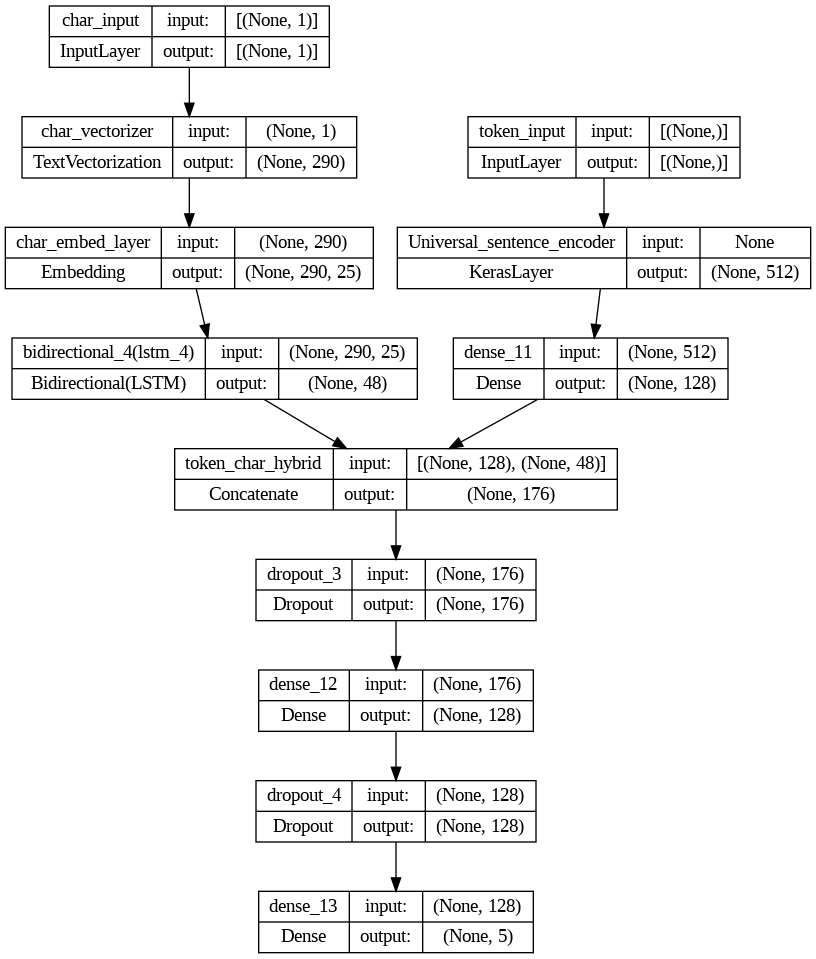

In [268]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True, show_layer_names=True)

In [269]:
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")

In [270]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [271]:
token_char_train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) #.batch(32).prefetch(tf.data.AUTOTUNE)
token_char_train_labels =  tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
token_char_train_dataset = tf.data.Dataset.zip((token_char_train_data, token_char_train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

token_char_val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))#.batch(32).prefetch(tf.data.AUTOTUNE)
token_char_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
token_char_val_dataset = tf.data.Dataset.zip((token_char_val_data, token_char_val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
#token_char_test_dataset = tf.data.Dataset.from_tensor_slices(([test_dataset, test_char], test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [272]:
token_char_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [273]:
model_4.fit(token_char_train_dataset,
            epochs = 3,
            steps_per_epoch = int(0.1*len(token_char_train_dataset)),
            validation_data = token_char_val_dataset,
            validation_steps = int(0.1*len(token_char_val_dataset))
            )

Epoch 1/3
562/562 [==============================] - 40s 55ms/step - loss: 0.9726 - accuracy: 0.6121 - val_loss: 0.7730 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 35s 63ms/step - loss: 0.7975 - accuracy: 0.6929 - val_loss: 0.7181 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 30s 54ms/step - loss: 0.7846 - accuracy: 0.6979 - val_loss: 0.7022 - val_accuracy: 0.7367


In [274]:
model_4.evaluate(token_char_val_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.7070 - accuracy: 0.7304


[0.7069522738456726, 0.7303720116615295]

## Make predictions using the token char model hybrid

In [275]:
model_4_pred_probs = model_4.predict(token_char_val_dataset)
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)

945/945 [==============================] - 22s 20ms/step


In [276]:
model_4_results = evaluate_model(val_labels_encoded, model_4_pred)

# Feature engineering
Data augmentation is Feature engineering, we need to add the knowledge of the line number into the model

* abstracts come in a specific order. discussion is like that too.

* How do we add "feature engineering" as extra sources of data to our model?

* We can design a label sequence optimization layer.

# Model 5: Transfer learning with pretrained token embedding + character embedding + positional embedding.

In [277]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note** any engineered features used need to be available at test time. This case, line numbers and total lines are available.

## Create positional embeddings

In [278]:
#How many different line numbers?
train_df["line_number"].value_counts()


0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

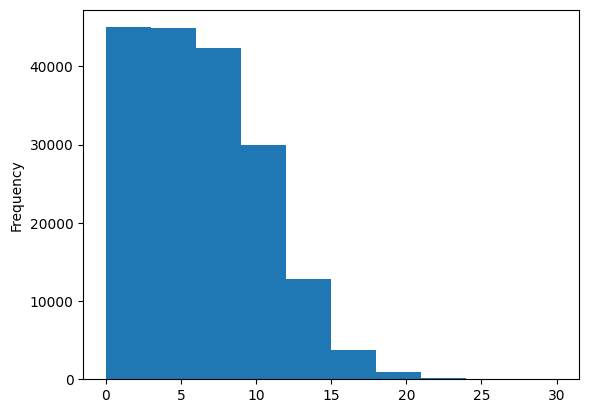

In [279]:
train_df.line_number.plot.hist()

In [280]:
# Use tensorflow to create one-hot-encoded line number.

train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth =15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [281]:
val_line_number_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth =15)
test_line_number_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth =15)

<Axes: ylabel='Frequency'>

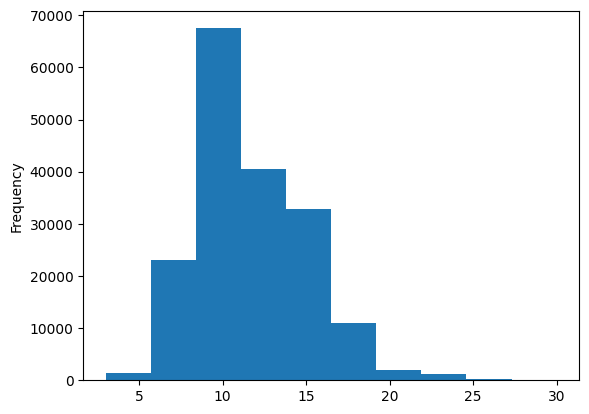

In [282]:
train_df.total_lines.plot.hist()

In [283]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

### One hot encode total line numbers

In [284]:
train_total_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20)
val_total_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
test_total_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)

### Build Tribrid embedding model

1. Create a token-level model
2. Create a char-level model
3. Create a model for the line number
4. Create a model for the total line number
5. Combine the outputs of Char and Token level models using tf.keras.layers.Concatenate
6. Combine the outputs of Line number / total line / char + Token model using tf.keras.layers.Concatenate
7. Create output layers to accept the tribred embedding and output label probabilities
8. Construct model with line/ total line / char + token inputs

In [285]:
# 1 Token inputs
token_inputs = layers.Input(shape = [], dtype =tf.string, name ="token_input" )
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2 Char inputs
char_inputs =  layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3 Line number model
# inputs, shape = ?
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32 , name = "line_number_input")
# dense layer with 32 units & relu activation
line_number_embedding  = layers.Dense(32, activation="relu")(line_number_inputs)
# Combine inputs and dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                             outputs=line_number_embedding)


#4 Total lines model
# inputs, shape = ?
total_lines_inputs = layers.Input(shape = (20,), dtype = "int64", name = "total_lines_input")
# Dense layer with 32 units & relu activation
total_lines_embedding  = layers.Dense(32, activation="relu")(total_lines_inputs)
# Combine inputs and dense layer into model
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                             outputs=total_lines_embedding)

# 5.  Combine token and char embeddings into hybrid embeddings
combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                       char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
combined_embeddings_50 = layers.Dropout(0.5)(z)

# 6. Combine line number and total line number embeddings
tribrid_embeddings =  tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                           total_lines_model.output,
                                                                                           combined_embeddings_50])

# Create output layer
output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(tribrid_embeddings)

# 7. Create model
model_5 = tf.keras.Model(inputs = [line_number_inputs, total_lines_inputs, token_inputs, char_inputs,],
                       outputs = output_layer, name = "Model_5_tribrid")

In [286]:
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [287]:
train_total_one_hot.shape

TensorShape([180040, 20])

In [288]:
# # 3 Line number model
# # inputs, shape = ?
# line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32 , name = "line_number_input")
# # dense layer with 32 units & relu activation
# line_number_embedding  = layers.Dense(32, activation="relu")(line_number_inputs)
# # Combine inputs and dense layer into model
# line_number_model = tf.keras.Model(inputs=line_number_inputs,
#                              outputs=line_number_embedding)


# #4 Total lines model
# # inputs, shape = ?
# total_lines_inputs = layers.Input(shape = (20,), dtype = "int64", name = "total_lines_input")
# # Dense layer with 32 units & relu activation
# total_lines_embedding  = layers.Dense(32, activation="relu")(total_lines_inputs)
# # Combine inputs and dense layer into model
# total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
#                              outputs=total_lines_embedding)

# # 5.  Combine token and char embeddings into hybrid embeddings
# combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

# z = layers.Dense(256, activation="relu")(combined_embeddings)
# combined_embeddings_50 = layers.Dropout(0.5)(z)

# # 6. Combine line number and total line number embeddings
# tribrid_embeddings =  tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, total_lines_model.output, combined_embeddings_50])

# # Create output layer
# output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(tribrid_embeddings)

# # 7. Create model
# model_5 = tf.keras.Model(inputs = [token_inputs, char_inputs, line_number_inputs, total_lines_inputs],
#                        outputs = output_layer, name = "Model_5_tribrid")


In [289]:
model_5.summary()

Model: "Model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0]

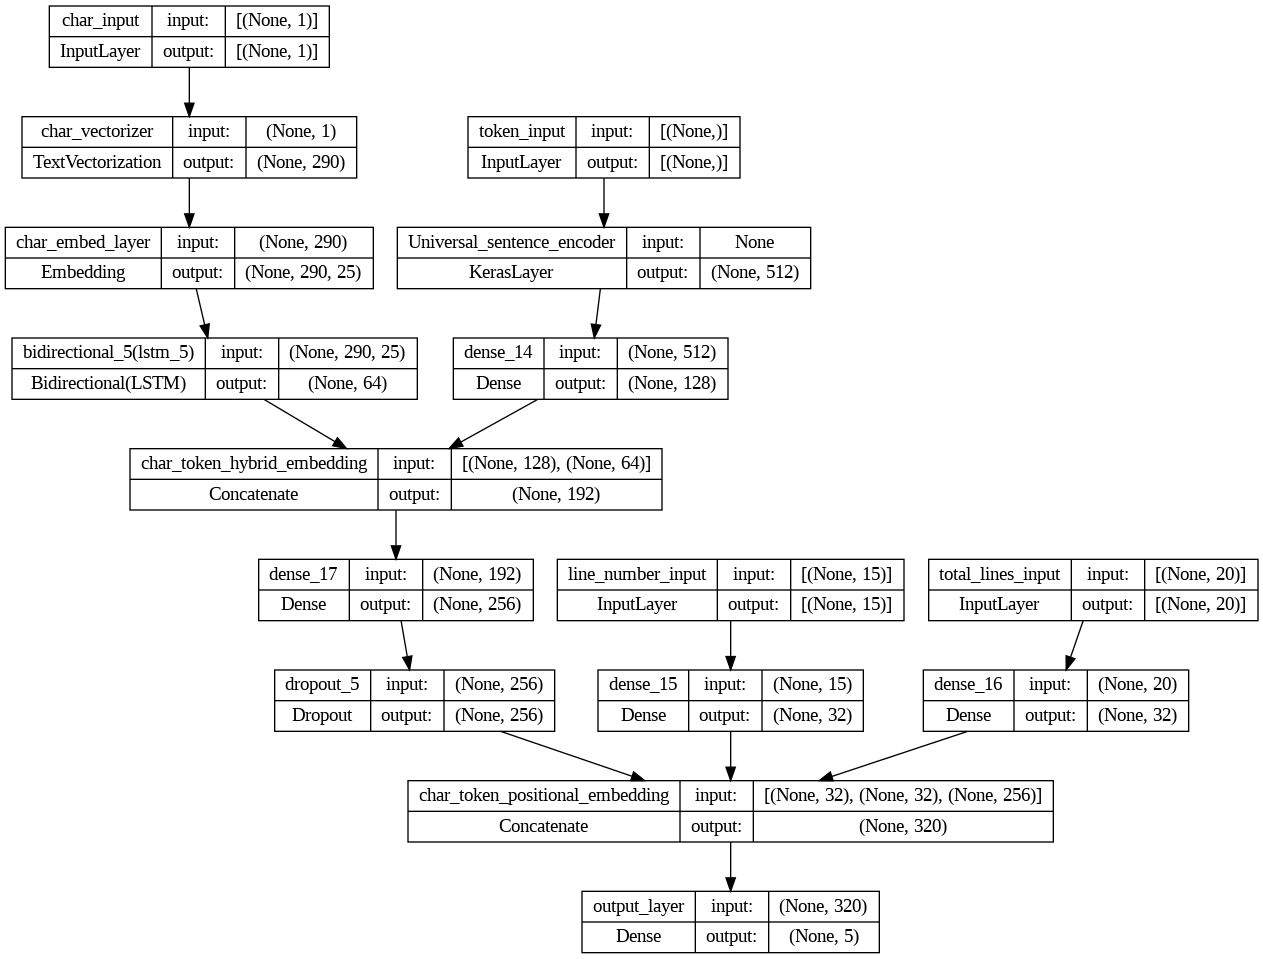

In [290]:
# Plot model 5 to explore visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes =True, show_layer_names=True)


In [291]:
# Compile
# Labels smoothing is to prevent overfitting, assigns numbers to the other outputs (in our example 5 outputs) gives them values
# Computersearch pyvision has more image smoothing info

model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=  tf.keras.optimizers.Adam(),
                metrics = "accuracy"
                )

In [292]:
# token_char_train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) #.batch(32).prefetch(tf.data.AUTOTUNE)
# token_char_train_labels =  tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# token_char_train_dataset = tf.data.Dataset.zip((token_char_train_data, token_char_train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [293]:
# val_line_number_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth =15)
# test_line_number_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth =15)

# train_total_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20)
# val_total_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
# test_total_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)

In [294]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [295]:
train_char[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [296]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth =15)

In [297]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_one_hot, train_sentences, train_char))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_one_hot, val_sentences, val_char))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [298]:
# Check input shape
train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [299]:
# Check input shape
train_char_token_pos_dataset.element_spec


((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

In [300]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        epochs = 3,
                        steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 56ms/step - loss: 1.0899 - accuracy: 0.7265 - val_loss: 0.9815 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 37s 65ms/step - loss: 0.9663 - accuracy: 0.8161 - val_loss: 0.9517 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9502 - accuracy: 0.8217 - val_loss: 0.9369 - val_accuracy: 0.8318


In [301]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 25s 22ms/step


array([[0.51446074, 0.10063593, 0.01091896, 0.3565524 , 0.01743202],
       [0.5511828 , 0.09657718, 0.04889289, 0.2932943 , 0.01005281],
       [0.3074753 , 0.10888665, 0.14040564, 0.3731717 , 0.07006072],
       ...,
       [0.02965412, 0.08758672, 0.03404779, 0.03011444, 0.8185969 ],
       [0.03716186, 0.3471865 , 0.08246525, 0.02958426, 0.50360215],
       [0.1616864 , 0.6641215 , 0.07126791, 0.04520386, 0.05772026]],
      dtype=float32)

In [302]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [303]:
model_5_results= evaluate_model(model_5_preds, val_labels_encoded)
model_5_results

{'accuracy': 0.8331457698927578,
 'precision': 0.8367844868631731,
 'recall': 0.8331457698927578,
 'f1': 0.8344336798483173}

# Compare all the model results and test model on test data

In [304]:
results_summary1 = pd.DataFrame({"Baseline": baseline_results,
                                "Custom_token": model_1_results,
                                "Pretrained_token": model_2_results,
                                "Custom_char": model_3_results,
                                "Hybrid_char_token": model_4_results,
                                "Tribrid":model_5_results} )

In [305]:
results_summary = results_summary1.transpose()
results_summary

,accuracy,precision,recall,f1
Baseline,0.721832,0.783563,0.721832,0.744740
Custom_token,0.785582,0.782329,0.785582,0.783253
Pretrained_token,0.712631,0.713067,0.712631,0.709581
Custom_char,0.353436,0.480367,0.353436,0.330281
Hybrid_char_token,0.730372,0.733937,0.730372,0.728067
Tribrid,0.833146,0.836784,0.833146,0.834434


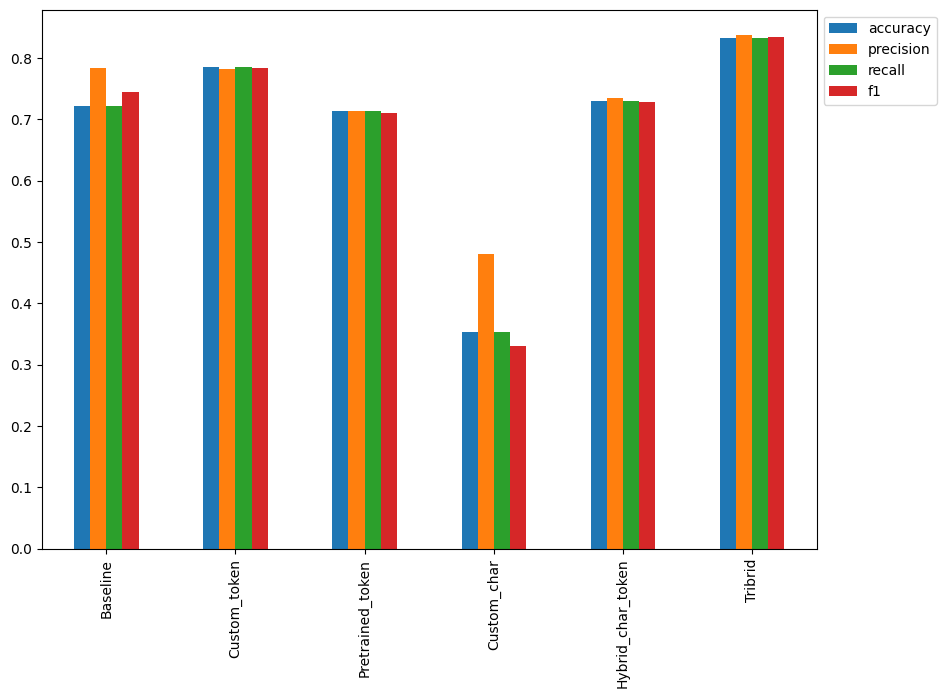

In [306]:
import matplotlib.pyplot as plt
results_summary.plot(kind = "bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

In [307]:
#Save model
model_5.save("SkimLitModel5")


In [308]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-01-30 04:55:04--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip.1’

skimlit_tribrid_mod 100%[===================>] 917.61M  23.8MB/s    in 27s     

2024-01-30 04:55:32 (34.0 MB/s) - ‘skimlit_tribrid_model.zip.1’ saved [962182847/962182847]

mkdir: cannot create directory ‘skimlit_gs_model’: File exists
Archive:  skimlit_tribrid_model.zip
replace skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [309]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization


model_path = "skimlit_gs_model/skimlit_tribrid_model/"
#load model from git
loaded_model = tf.keras.models.load_model(model_path)


In [310]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 33s 32ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

## The Challenges

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test sample
2. Find the most wrong predictions from 1 ( these are the samples where the model has predicted the wrong label with the highest predction probabilites)

In [311]:
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_pred_probs

945/945 [==============================] - 36s 36ms/step


array([[0.49693584, 0.09958737, 0.01160351, 0.37095577, 0.02091751],
       [0.49750713, 0.11349739, 0.03977856, 0.3369411 , 0.01227578],
       [0.286786  , 0.1087275 , 0.13145249, 0.4051689 , 0.06786516],
       ...,
       [0.03259365, 0.09631421, 0.03530622, 0.03110423, 0.8046817 ],
       [0.03149456, 0.30440855, 0.06456723, 0.02800333, 0.57152635],
       [0.21597447, 0.58115804, 0.10669407, 0.03717945, 0.05899395]],
      dtype=float32)

In [312]:
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis =1)
loaded_model_preds[0:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 3, 2])>

In [313]:
# Try with test dataset to check predictions.
test_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                    test_total_one_hot,
                                                    test_sentences,
                                                    test_char))
test_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_dataset = tf.data.Dataset.zip((test_pos_data, test_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [314]:
test_pred_probs = loaded_model.predict(test_pos_dataset)
test_pred_probs.shape

942/942 [==============================] - 18s 19ms/step


(30135, 5)

In [315]:
# test_pred_probs_sq = tf.squeeze(test_pred_probs )
# test_pred_probs_sq.shape

In [316]:
test_preds = tf.argmax(test_pred_probs, axis = 1)
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 1, 0])>

In [317]:
loaded_model_test_results = evaluate_model(test_labels_encoded, test_preds)
loaded_model_test_results

{'accuracy': 0.8257176041148167,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

In [318]:
%%time
import numpy as np
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

CPU times: user 14.9 s, sys: 767 ms, total: 15.7 s
Wall time: 14.8 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [319]:
test_df["Predictions"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1)
test_df["Correct"] = test_labels_encoded == test_preds
test_df.head(20)

,target,text,line_number,total_lines,Predictions,pred_prob,Correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.523885,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.351917,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.802459,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652782,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.665070,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.881815,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.529839,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.568003,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.461431,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.537819,True


In [320]:
top_10_wrong = test_df[test_df["Correct"]==False].sort_values(by = "pred_prob", ascending = False)
top_10_wrong.head(10)

,target,text,line_number,total_lines,Predictions,pred_prob,Correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.946719,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.934974,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.928262,False
10452,BACKGROUND,to validate the association between accommodat...,0,10,OBJECTIVE,0.918880,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.916908,False
23630,RESULTS,the primary outcome was to evaluate changes in...,6,14,METHODS,0.915075,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.914345,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.910313,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.906662,False


In [321]:
for row in top_10_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_probs, _ = row
  print(f"Target:{target}")
  print(f"Text: {text}")
  print(f"Line Number: {line_number}")
  print(f"Total Lines: {total_lines}")
  print(f"Prediction: {prediction}")
  print(f"Prediction Probability: {pred_probs}")

Target:CONCLUSIONS
Text: symptom outcomes will be assessed and estimates of cost-effectiveness made .
Line Number: 4
Total Lines: 6
Prediction: METHODS
Prediction Probability: 0.9467191696166992
Target:METHODS
Text: pretest-posttest .
Line Number: 1
Total Lines: 11
Prediction: BACKGROUND
Prediction Probability: 0.9349740743637085
Target:BACKGROUND
Text: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .
Line Number: 0
Total Lines: 12
Prediction: OBJECTIVE
Prediction Probability: 0.9309859275817871
Target:RESULTS
Text: the primary endpoint is the cumulative three-year hiv incidence .
Line Number: 4
Total Lines: 13
Prediction: METHODS
Prediction Probability: 0.9282616972923279
Target:BACKGROUND
Text: to validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the optical quality analysis system ( oqas , visiometrics , terrassa , spain ) , and to investigate associations amo

In [322]:
top_10_wrong[0:10].itertuples()

In [323]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as file:
  example_abstracts = json.load(file)

example_abstracts

--2024-01-30 05:41:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-01-30 05:41:05 (67.6 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [324]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [325]:
# Parse using spacy
from spacy.lang.en import English
nlp = English()

sentencizer = nlp.add_pipe("sentencizer") # a sentence splitting pipeline object

doc = nlp(example_abstracts[0]["abstract"])
abstract_line = [str(sent) for sent in list(doc.sents)]  # returns detected sentences from doc in string type
abstract_line

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [326]:
# get total lines in sampl
total_lines_in_sample = len(abstract_line)

# Go through each line in abstract and crewate a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_line):
  sample_dict ={}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample-1
  sample_lines.append(sample_dict)

sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [327]:
# Get all line number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
#one hot encode
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth =15)

# Get all total lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
#one hot encode
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth =20)



In [328]:
# split char
abstract_chars = [split_chars(sentence) for sentence in abstract_line]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [329]:

# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_line),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step
CPU times: user 1.24 s, sys: 15.4 ms, total: 1.26 s
Wall time: 1.28 s


array([[0.26448247, 0.1105424 , 0.01762423, 0.5750657 , 0.03228524],
       [0.06927066, 0.03808297, 0.7078093 , 0.09543166, 0.08940544],
       [0.13772689, 0.04937518, 0.54679686, 0.16341293, 0.1026881 ],
       [0.09659056, 0.17111637, 0.5257439 , 0.07601641, 0.13053277],
       [0.04459698, 0.08888115, 0.4567545 , 0.04623033, 0.363537  ],
       [0.03265214, 0.1462643 , 0.517485  , 0.04088319, 0.2627154 ],
       [0.03290154, 0.17796215, 0.07166825, 0.02870874, 0.6887593 ],
       [0.0184372 , 0.1349517 , 0.3208419 , 0.03389723, 0.49187198]],
      dtype=float32)

In [330]:
test_abstract_pred = tf.argmax(test_abstract_pred_probs, axis =1)
test_abstract_pred

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [331]:
test_pred_abstract_classes = [label_encoder.classes_[pred] for pred in test_abstract_pred]

In [332]:
for i, line in enumerate(abstract_line):
  print(f"{test_pred_abstract_classes[i]}: {line}")




OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [333]:
checkpoint_filepath = '/ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                               save_weights_only = True,
                                                               monitor= 'val_accuracy',
                                                               save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)




In [334]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        epochs = 100,
                        steps_per_epoch = int(0.9 * len(train_char_token_pos_dataset)),
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(0.9 * len(val_char_token_pos_dataset)),
                        callbacks = [model_checkpoint_callback, early_stop])

Epoch 1/100
 289/5064 [>.............................] - ETA: 4:12 - loss: 0.9541 - accuracy: 0.8244

KeyboardInterrupt: 

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

# Try using GloVe embeddings
#git clone https://github.com/stanfordnlp/glove


In [38]:
import os
os.environ["KERAS_BACKEND"] ="tensorflow"
import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers

In [ ]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=20)
text_ds = tf_data.Dataset.from_tensor_slices(train_samples).batch(32)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
voc

In [40]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-01-30 07:59:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2024-01-30 08:01:51 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [41]:
path_to_glove = "/content/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove) as f:
  for line in f:
    word, coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] =coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embeddings_index["the"]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [43]:
rct_20k_text_vocab[0:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [44]:
vectorize_layer.get_vocabulary()[0:10]
word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))

In [45]:
output_test = vectorize_layer([["this is a test"]])
output_test

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 23,  20,   8, 128,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])>

In [46]:
num_tokens = max_tokens
embedding_dim = 100
hits = 0
misses = 0

#prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will all be zeros
    # this includes the representation for padding and OOV
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses+=1

print("converted %d words (%d misses)" % (hits, misses))

converted 29730 words (35111 misses)


In [347]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
from keras.layers import Embedding

embedding_layer =  Embedding(
    num_tokens,
    embedding_dim,
    trainable =False,
)

embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [357]:
# input_layer = keras.Input(shape=(None,), dtype="int32")
# embedded_sequences = embedding_layer(input_layer)
# x = layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dropout(0.5)(x)

# output_layer = layers.Dense(len(class_names), activation ="softmax")(x)
# model_6 = keras.Model(input_layer, output_layer)
# model_6.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6800000   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 dense_20 (Dense)            (None, None, 128)         16512     
                                                                 
 dropout_7 (Dropout)         (None, None, 128)         0         
                                                          

In [50]:
# Conv1D with token embeddings

inputs = layers.Input(shape = (1,), dtype=tf.string)
text_vectors = vectorize_layer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation ="relu")(token_embeddings)
x =  layers.GlobalAveragePooling1D()(x)
# x = layers.Dense(6, activation = "relu")(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x) #(5 different labels)
model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")
model_6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 55, 100)           6800000   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            32064     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [370]:
x_train = vectorize_layer(np.array([[string] for string in train_sentences])).numpy()
x_val = vectorize_layer(np.array([[string] for string in val_sentences])).numpy()



In [372]:
x_val[0], val_sentences[0]

(array([ 3242,  6471,     6, 21172, 57315,     3,     8,   280,  2816,
         6657,  2596,   692,    58,   317,     5,    12,     7,  2166,
          569,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]),
 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .')

In [364]:
train_labels_numpy = train_df.target.to_numpy().reshape(-1,1)
val_labels_numpy = val_df.target.to_numpy().reshape(-1,1)

In [365]:
# # One hot encoded labels
# from sklearn.preprocessing import OneHotEncoder
# import tensorflow as tf

# one_hot_encode = OneHotEncoder(sparse_output=False)
# train_labels_one_hot = one_hot_encode.fit_transform(train_df.target.to_numpy().reshape(-1,1))
# val_labels_one_hot = one_hot_encode.transform(val_df.target.to_numpy().reshape(-1,1))
# test_labels_one_hot = one_hot_encode.transform(test_df.target.to_numpy().reshape(-1,1))

In [49]:
# model_6.compile(loss="sparse_categorical_crossentropy",
#                 optimizer = tf.keras.optimizers.SGD(),
#                 metrics="accuracy")

In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
history_6 = model_6.fit(train_dataset,
            epochs = 20,
            steps_per_epoch = int(len(train_dataset)/32),
            batch_size = 32,
            validation_data = val_dataset,
            validation_steps= int(len(val_dataset)/32)
            )

Epoch 1/20
703/703 [==============================] - 5s 7ms/step - loss: 0.6030 - accuracy: 0.7848 - val_loss: 0.6095 - val_accuracy: 0.7791
Epoch 2/20
703/703 [==============================] - 3s 4ms/step - loss: 0.5881 - accuracy: 0.7895 - val_loss: 0.5894 - val_accuracy: 0.7847
Epoch 3/20
703/703 [==============================] - 4s 5ms/step - loss: 0.5844 - accuracy: 0.7899 - val_loss: 0.5906 - val_accuracy: 0.7844
Epoch 4/20
703/703 [==============================] - 5s 7ms/step - loss: 0.5982 - accuracy: 0.7850 - val_loss: 0.5793 - val_accuracy: 0.7903
Epoch 5/20
703/703 [==============================] - 3s 5ms/step - loss: 0.5934 - accuracy: 0.7826 - val_loss: 0.5742 - val_accuracy: 0.7929
Epoch 6/20
703/703 [==============================] - 4s 5ms/step - loss: 0.5884 - accuracy: 0.7890 - val_loss: 0.5953 - val_accuracy: 0.7797
Epoch 7/20
703/703 [==============================] - 3s 4ms/step - loss: 0.5903 - accuracy: 0.7888 - val_loss: 0.5745 - val_accuracy: 0.7887
Epoch 

703/703 [==============================] - 0s 469us/step - loss: 0.7017 - accuracy: 0.7778 - val_loss: 0.5829 - val_accuracy: 0.7908


In [69]:
model_6.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5895 - accuracy: 0.7894


[0.5894922614097595, 0.7893552184104919]

In [73]:
model_6_pred_probs = model_6.predict(test_dataset)

942/942 [==============================] - 4s 4ms/step


In [74]:
model_6_pred = tf.argmax(model_6_pred_probs, axis = 1)

In [76]:
model_6_results =  evaluate_model(model_6_pred, test_labels_encoded)

In [77]:
model_6_results

{'accuracy': 0.7817487970798075,
 'precision': 0.7954288437366089,
 'recall': 0.7817487970798075,
 'f1': 0.7864653873201022}